# Import bibliotek

In [64]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import pathlib
import os
from os import listdir
import glob
from PIL import Image
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    LayerNormalization,
    AveragePooling2D,
    RandomFlip,
    RandomRotation,
    RandomTranslation,
    RandomCrop,
    RandomBrightness,
    RandomContrast,
    RandomZoom
)

cinic_directory_train = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\train' #'C:\\Users\\48695\\Documents\\Studia\\DLM\\Projekt CNN\\cinic-10_image_classification_challenge-dataset\\train'
cinic_directory_test = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\test' #'C:\\Users\\48695\\Documents\\Studia\DLM\\Projekt CNN\\cinic-10_image_classification_challenge-dataset\\test'

SEED = 1337
splitfolder = 'D:\\GitHub\\cinic-10_image_classification_challenge-dataset\\'+str(SEED)

tf.random.set_seed(SEED)

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax'
nb_epochs=20
batch_size_choice=16
image_size=(32, 32)
loss_func='categorical_crossentropy'

# Funkcje pomocnicze

In [34]:
def show_training_validation_loss_and_metrics(model,metrics):
    f,ax=plt.subplots(2,1,figsize=(10,10)) 

    #Assigning the first subplot to graph training loss and validation loss
    ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
    ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')

    #Plotting the training accuracy and validation accuracy
    for metric in metrics:
        ax[1].plot(model.history.history[metric],label='Training '+metric)
        ax[1].plot(model.history.history['val_'+metric],label='Validation '+metric)

    plt.legend() 

# Wczytanie danych

In [6]:
splitfolders.ratio(cinic_directory_train, output=splitfolder,
    seed=SEED, ratio=(.7, .1, .2), group_prefix=None, move=False)

Copying files: 90000 files [01:40, 893.06 files/s]


In [80]:
datagen_train = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    brightness_range = [0.9,1.1],
    channel_shift_range = 50
    )
datagen_valid = ImageDataGenerator(samplewise_center=False)

In [81]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    splitfolder+'\\train',
    seed=SEED,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    splitfolder+'\\val',
    seed=SEED,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# load and iterate validation dataset
test_it = datagen_valid.flow_from_directory(
    splitfolder+'\\test',
    seed=SEED,
    target_size=image_size,
    batch_size=batch_size_choice,
    color_mode="rgb",
    class_mode="categorical",
)
# loading in the data
# train_ds = keras.preprocessing.image_dataset_from_directory(
#     splitfolder+'\\train',
#     seed=SEED,
#     image_size=image_size,
#     batch_size=batch_size_choice,
#     label_mode = "categorical"
# ) 
# validation_ds = keras.preprocessing.image_dataset_from_directory(
#     splitfolder+'\\val',
#     seed=SEED,
#     image_size=image_size,
#     batch_size=batch_size_choice,
#     label_mode = "categorical"
# )
# test_ds = keras.preprocessing.image_dataset_from_directory(
#     splitfolder+'\\test',
#     seed=SEED,
#     image_size=image_size,
#     batch_size=batch_size_choice,
#     label_mode = "categorical"
# )

Found 63000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.
Found 18000 images belonging to 10 classes.


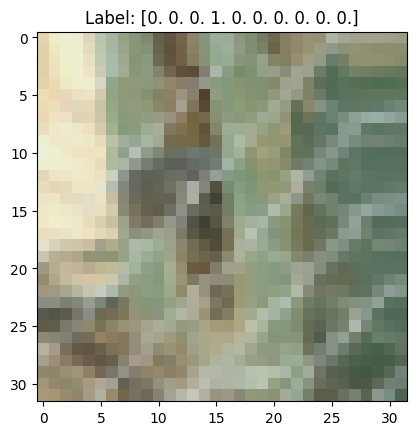

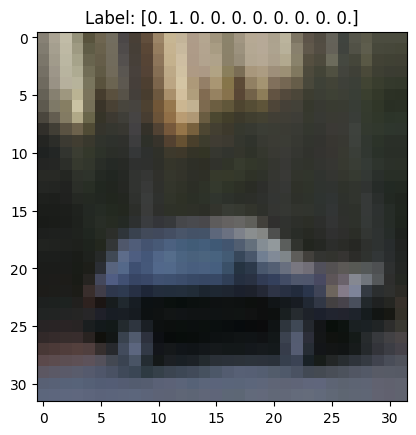

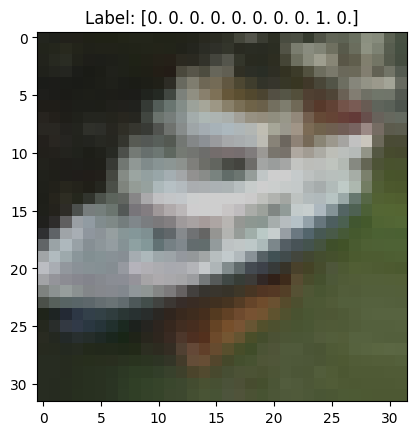

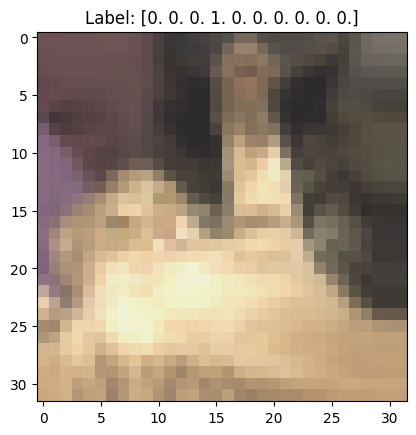

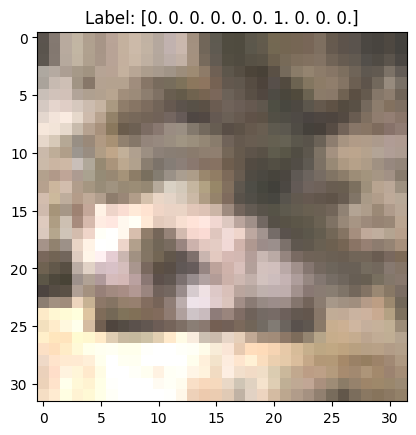

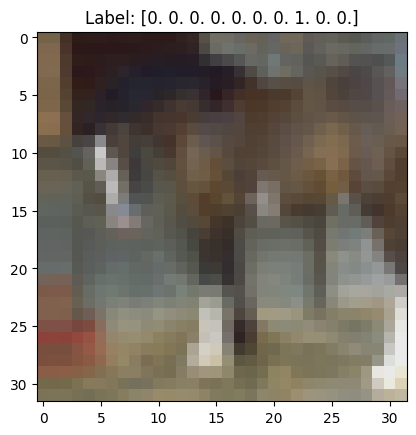

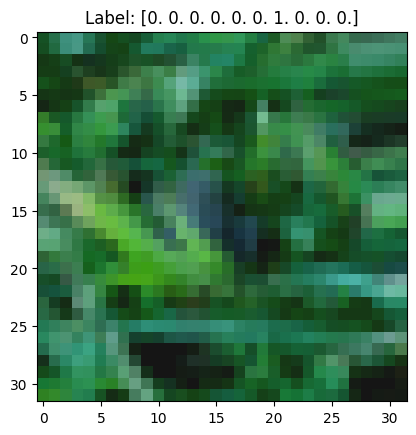

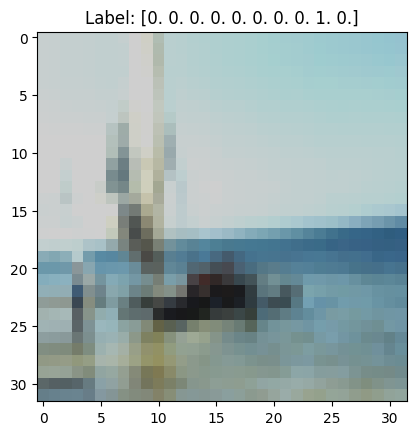

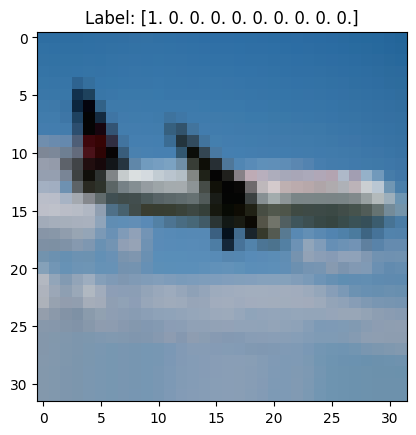

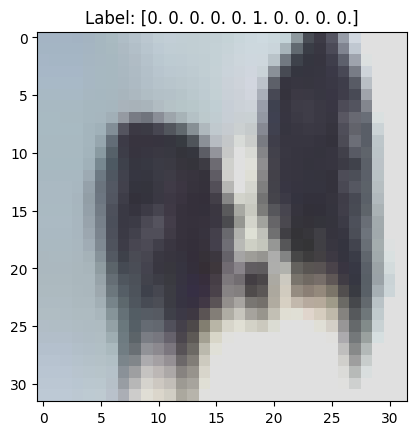

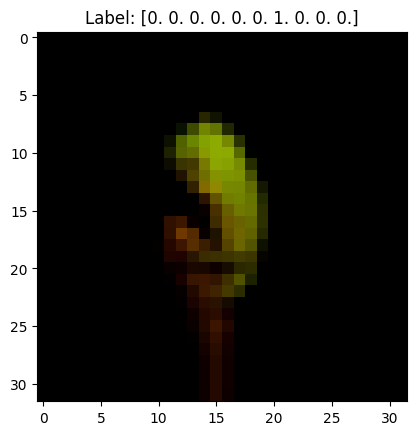

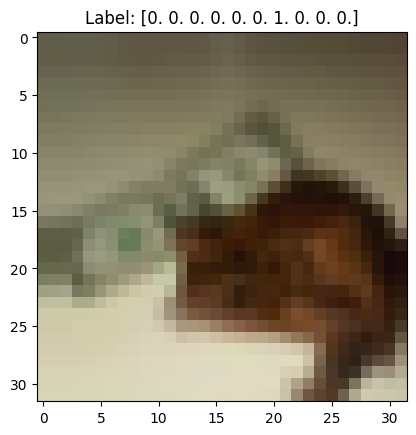

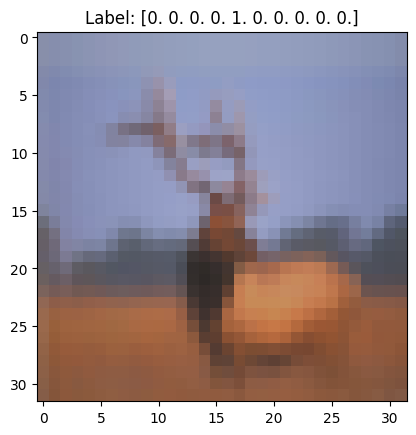

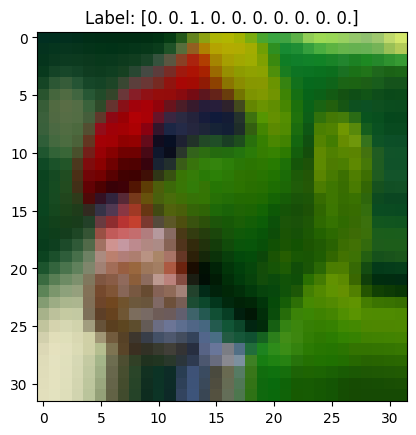

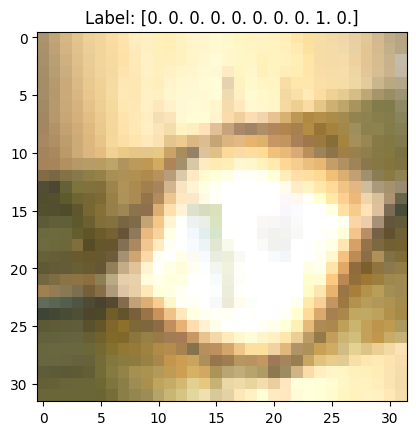

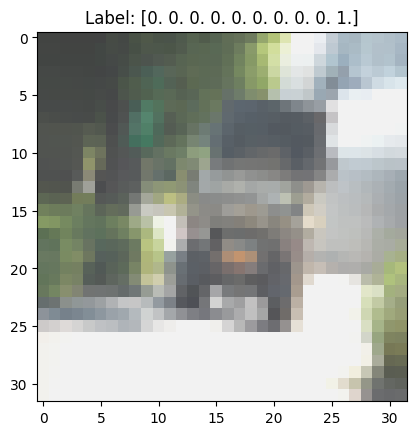

In [82]:
# # Pobranie kilku partii danych z iteratora train_it
num_images_to_display = 1
for i in range(num_images_to_display):
    batch = next(iter(train_it))  # Pobranie kolejnej partii danych
    images, labels = batch[0], batch[1]  # Podział partii na obrazy i etykiety
    for j in range(len(images)):
        plt.imshow(images[j].astype('uint8'))  # Wyświetlenie obrazu
        plt.title(f"Label: {labels[j]}")  # Wyświetlenie etykiety obrazu
        plt.show()
# Pobierz jedną partię danych z train_ds
# for images, labels in train_ds.take(1):
#     first_image = images[0]  # Pobierz pierwszy obraz
#     plt.imshow(first_image.numpy().astype("uint8"))  # Wyświetl obraz
#     plt.axis('off')  # Wyłącz oś
#     plt.show()

In [5]:

# data_augmentation = Sequential([
#   RandomFlip("horizontal",seed=SEED),
#   RandomRotation(0.1,seed=SEED),
#   RandomBrightness(0.1,seed=SEED),
#   RandomContrast(0.1,seed=SEED),
#   RandomTranslation(0.1,0.1,seed=SEED),
#   RandomZoom(0.1,seed=SEED),
#   RandomCrop(24,24,seed=SEED)
# ])

# for images, labels in train_ds.take(1):
#     # Iteruj po każdym obrazie w partii
#     for i in range(len(images)):
#         plt.imshow(data_augmentation(images[i]).numpy().astype("uint8"))  # Wyświetl obraz
#         plt.title(f"Label: {labels[i].numpy()}")  # Wyświetl etykietę obrazu
#         plt.axis('off')  # Wyłącz oś
#         plt.show()


In [83]:
class_names= ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
num_classes = len(class_names)
print(class_names)

metrics = ['categorical_accuracy','AUC','Precision','Recall', tfa.metrics.F1Score(num_classes=num_classes, threshold=0.5, average='weighted')]

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [154]:
# Inicjalizacja słownika do zliczania liczby obrazów w każdej klasie
#class_count = {class_name: 0 for class_name in class_names}

# Przechodzenie przez zbiór danych i zliczanie obrazów w każdej klasie
#for images, labels in train_ds:
#    for label in labels.numpy():
#        class_count[class_names[label]] += 1

# Wyświetlenie liczby obrazów w każdej klasie
#for class_name, count in class_count.items():
#    print(f"Liczba obrazów w klasie {class_name}: {count}")

# Dane do wykresu słupkowego
#class_names = list(class_count.keys())
#counts = list(class_count.values())

# Tworzenie wykresu słupkowego
#plt.figure(figsize=(10, 6))
#plt.bar(class_names, counts, color='skyblue')
#plt.xlabel('Klasa')
#plt.ylabel('Liczba obrazów')
#plt.title('Liczba obrazów w każdej klasie')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()

# Wyświetlenie wykresu
#plt.show()

# Architektura pierwszego modelu

In [84]:
model1 = Sequential()

# model1.add(RandomFlip("horizontal",seed=SEED))
# model1.add(RandomRotation(0.1,seed=SEED))
# model1.add(RandomBrightness(0.1,seed=SEED))
# model1.add(RandomContrast(0.1,seed=SEED))
# model1.add(RandomTranslation(0.1,0.1,seed=SEED))
# model1.add(RandomZoom(0.1,seed=SEED))
# model1.add(RandomCrop(24,24,seed=SEED))

model1.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Dropout(0.2))
model1.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
model1.add(BatchNormalization())
model1.add(MaxPool2D((2, 2), strides=2, padding="same"))
model1.add(Flatten())
model1.add(Dense(units=512))
model1.add(Dropout(0.3))
model1.add(Dense(units=num_classes, activation="softmax"))

#model1_with_augmentation = Sequential([data_augmentation,model1])

In [85]:
model1.compile( 
    loss=loss_func,
    metrics=metrics
)

In [86]:
#model1.build((None,32,32,3))
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 32, 32, 256)       7168      
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 16, 16, 128)       295040    
                                                                 
 batch_normalization_21 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                     

In [87]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model1.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=nb_epochs,
    callbacks = [callback] 
)

Epoch 1/20
3937/3937 [==============================] - 67s 17ms/step - loss: 1.7623 - categorical_accuracy: 0.3646 - auc: 0.8174 - precision: 0.5339 - recall: 0.1639 - f1_score: 0.2333 - val_loss: 1.6018 - val_categorical_accuracy: 0.4308 - val_auc: 0.8499 - val_precision: 0.6124 - val_recall: 0.2721 - val_f1_score: 0.3157
Epoch 2/20
3937/3937 [==============================] - 67s 17ms/step - loss: 1.4508 - categorical_accuracy: 0.4687 - auc: 0.8785 - precision: 0.6561 - recall: 0.2760 - f1_score: 0.3614 - val_loss: 1.6179 - val_categorical_accuracy: 0.4638 - val_auc: 0.8619 - val_precision: 0.5527 - val_recall: 0.3454 - val_f1_score: 0.3818
Epoch 3/20
3937/3937 [==============================] - 66s 17ms/step - loss: 1.3592 - categorical_accuracy: 0.5085 - auc: 0.8940 - precision: 0.6865 - recall: 0.3266 - f1_score: 0.4164 - val_loss: 1.3824 - val_categorical_accuracy: 0.5229 - val_auc: 0.8911 - val_precision: 0.6791 - val_recall: 0.4000 - val_f1_score: 0.4502
Epoch 4/20
3937/3937 [

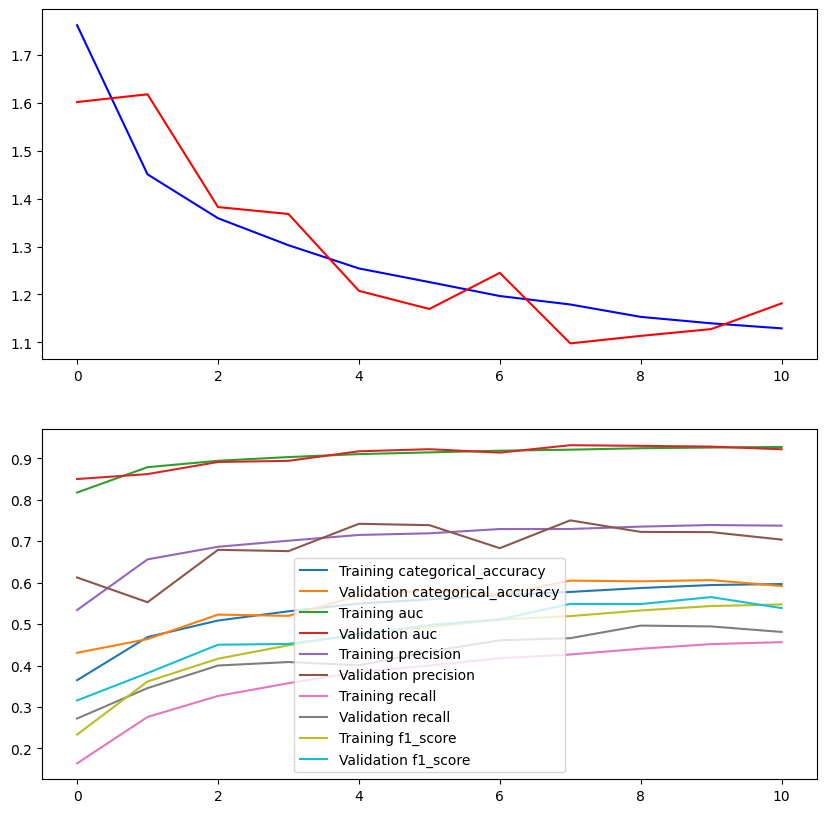

In [88]:
metrics2 = ['categorical_accuracy','auc','precision','recall','f1_score']
show_training_validation_loss_and_metrics(model1,metrics2)

In [89]:
model1.evaluate(test_it)

1125/1125 [==============================] - 8s 7ms/step - loss: 1.1716 - categorical_accuracy: 0.5916 - auc: 0.9233 - precision: 0.7013 - recall: 0.4814 - f1_score: 0.5374


[1.171607255935669,
 0.5915555357933044,
 0.9232758283615112,
 0.7013354897499084,
 0.4813888967037201,
 0.537350594997406]

# Architektura drugiego modelu

In [90]:
model2 = Sequential()
model2.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(32, 32, 3)))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model2.add(LayerNormalization())
model2.add(AveragePooling2D((2, 2), strides=2, padding="same"))
model2.add(LayerNormalization())
model2.add(Flatten())
model2.add(Dense(units=512))
model2.add(Dense(units=num_classes, activation="softmax"))

In [91]:
model2.compile( 
    loss=loss_func,
    metrics=metrics
)

In [92]:
model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 32, 32, 75)        2100      
                                                                 
 layer_normalization_13 (Lay  (None, 32, 32, 75)       150       
 erNormalization)                                                
                                                                 
 average_pooling2d_6 (Averag  (None, 16, 16, 75)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 50)        33800     
                                                                 
 layer_normalization_14 (Lay  (None, 16, 16, 50)       100       
 erNormalization)                                                
                                                     

In [93]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model2.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
3937/3937 [==============================] - 67s 17ms/step - loss: 1.9105 - categorical_accuracy: 0.3040 - auc: 0.7735 - precision: 0.5113 - recall: 0.0667 - f1_score: 0.2390 - val_loss: 1.6035 - val_categorical_accuracy: 0.4110 - val_auc: 0.8508 - val_precision: 0.6554 - val_recall: 0.1314 - val_f1_score: 0.1909
Epoch 2/20
3937/3937 [==============================] - 66s 17ms/step - loss: 1.6273 - categorical_accuracy: 0.4002 - auc: 0.8435 - precision: 0.6240 - recall: 0.1589 - f1_score: 0.2307 - val_loss: 1.6385 - val_categorical_accuracy: 0.4039 - val_auc: 0.8485 - val_precision: 0.5259 - val_recall: 0.2571 - val_f1_score: 0.2829
Epoch 3/20
3937/3937 [==============================] - 66s 17ms/step - loss: 1.5306 - categorical_accuracy: 0.4381 - auc: 0.8633 - precision: 0.6540 - recall: 0.2149 - f1_score: 0.2946 - val_loss: 1.4113 - val_categorical_accuracy: 0.4909 - val_auc: 0.8853 - val_precision: 0.7046 - val_recall: 0.2696 - val_f1_score: 0.3545
Epoch 4/20
3937/3937 [

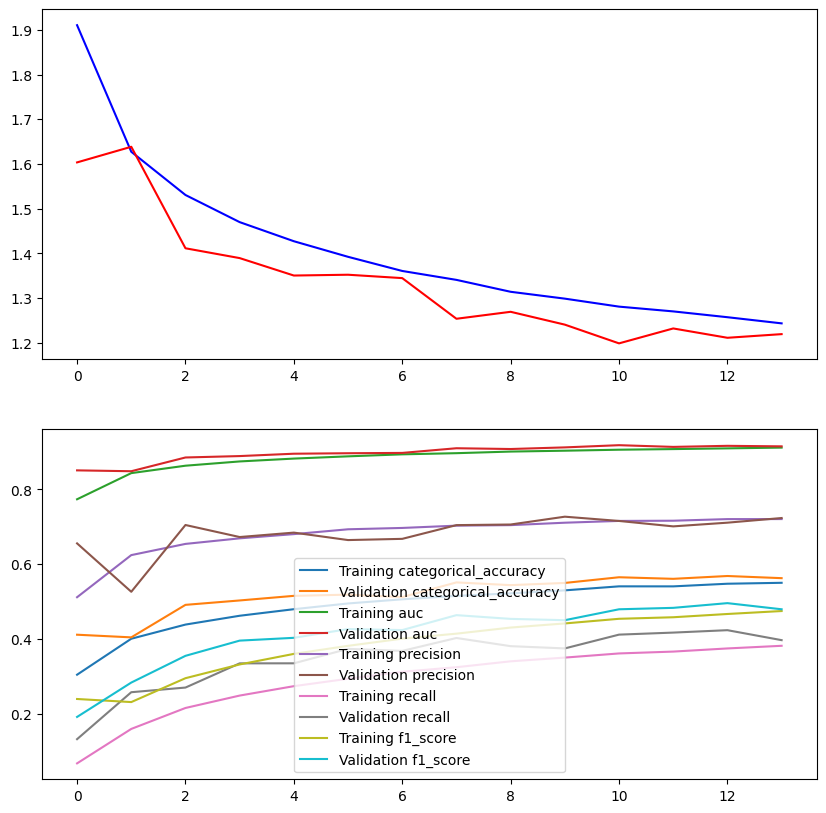

In [94]:
show_training_validation_loss_and_metrics(model2,metrics2)

In [95]:
model2.evaluate(test_it)

1125/1125 [==============================] - 8s 7ms/step - loss: 1.2034 - categorical_accuracy: 0.5626 - auc: 0.9176 - precision: 0.7296 - recall: 0.3987 - f1_score: 0.4823


[1.2033665180206299,
 0.5626111030578613,
 0.9176158308982849,
 0.7295923829078674,
 0.39872223138809204,
 0.48233336210250854]

# Architektura trzeciego modelu

In [96]:
model3 = Sequential()
model3.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="sigmoid", 
                 input_shape=(32, 32, 3)))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Conv2D(16, (3, 3), strides=1, padding="same", activation="sigmoid"))
model3.add(LayerNormalization())
model3.add(MaxPool2D((2, 2), strides=2, padding="same"))
model3.add(Flatten())
model3.add(Dense(units=1024))
model3.add(Dropout(0.3))
model3.add(Dense(units=num_classes, activation="softmax"))

model3.compile( 
    optimizer=optimiser,
    loss=loss_func,
    metrics=metrics
)

#model3.summary()

In [97]:
history = model3.fit(
    train_it,
    validation_data=valid_it,
    steps_per_epoch=train_it.samples/train_it.batch_size,
    validation_steps=valid_it.samples/valid_it.batch_size, 
    epochs=20, 
    callbacks = [callback]
)

Epoch 1/20
3937/3937 [==============================] - 66s 17ms/step - loss: 1.8489 - categorical_accuracy: 0.3001 - auc: 0.7852 - precision: 0.5839 - recall: 0.0575 - f1_score: 0.2104 - val_loss: 1.7250 - val_categorical_accuracy: 0.3547 - val_auc: 0.8258 - val_precision: 0.4800 - val_recall: 0.1611 - val_f1_score: 0.1831
Epoch 2/20
3937/3937 [==============================] - 66s 17ms/step - loss: 1.6159 - categorical_accuracy: 0.3955 - auc: 0.8461 - precision: 0.6245 - recall: 0.1537 - f1_score: 0.2194 - val_loss: 1.5049 - val_categorical_accuracy: 0.4406 - val_auc: 0.8684 - val_precision: 0.6539 - val_recall: 0.2290 - val_f1_score: 0.2894
Epoch 3/20
3937/3937 [==============================] - 65s 17ms/step - loss: 1.5297 - categorical_accuracy: 0.4299 - auc: 0.8637 - precision: 0.6493 - recall: 0.2051 - f1_score: 0.2767 - val_loss: 1.4614 - val_categorical_accuracy: 0.4511 - val_auc: 0.8788 - val_precision: 0.6018 - val_recall: 0.3032 - val_f1_score: 0.3321
Epoch 4/20
3937/3937 [

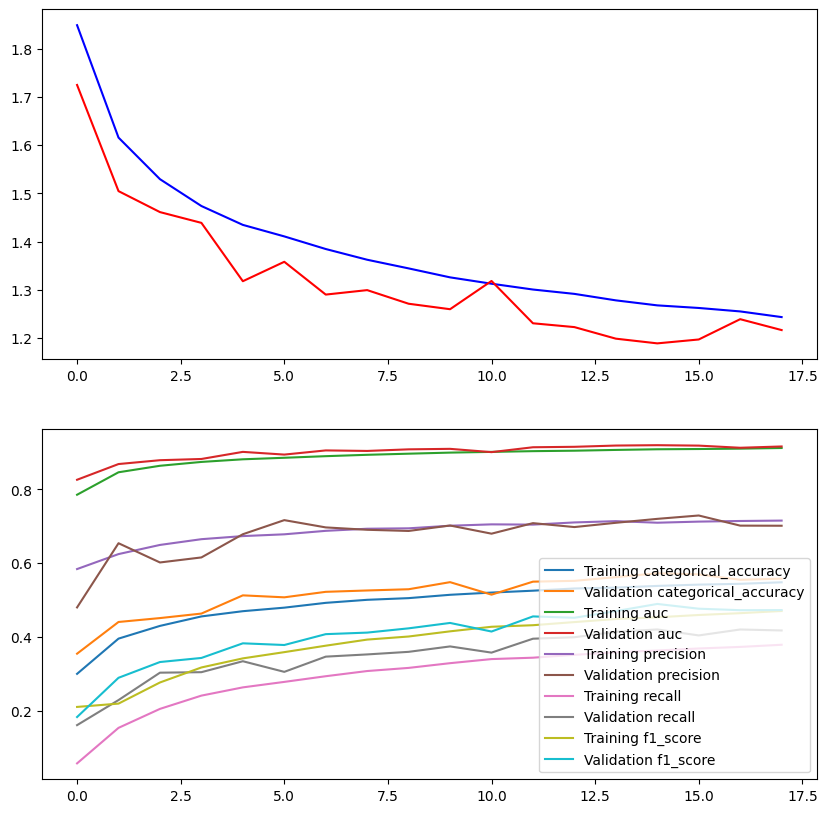

In [98]:
show_training_validation_loss_and_metrics(model3,metrics2)

In [99]:
model3.evaluate(test_it)

1125/1125 [==============================] - 8s 7ms/step - loss: 1.2032 - categorical_accuracy: 0.5601 - auc: 0.9179 - precision: 0.7063 - recall: 0.4151 - f1_score: 0.4717


[1.203201413154602,
 0.5601111054420471,
 0.9179272055625916,
 0.706343948841095,
 0.4150555431842804,
 0.4717205762863159]